# **SIGMA** **WEDGE** **HACKATHON**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

## **IMPLEMENTATION OF QUANTROCKET**

In [ ]:
from quantrocket.license import set_license
set_license("91f13353-e07e-11ee-9c63-c79777fc1750")

{'licensekey': '91f1........1750', 'software_license': {}}

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid', 'Symbol', 'Exchange'], vendors='usstock')
securities

,Symbol,Exchange
Sid,,
FIBBG000B9XRY4,AAPL,XNAS


In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("usstock1aapl",free = True)

{'status': 'success', 'msg': 'successfully created usstock1aapl bundle'}

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("usstock1aapl")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
from quantrocket import get_prices
price = get_prices("usstock1aapl", data_frequency='daily', sids="FIBBG000B9XRY4", start_date='2023-01-01', end_date='2023-12-31', fields=["Close"])

In [ ]:
price.to_csv('usstock1aapl.csv')

## **DATA UPLOADING AND VISUVALIZATION**

In [2]:
price=pd.read_csv('usstock1aapl.csv')
price

,Field,Date,FIBBG000B9XRY4
0,Close,2023-01-03,124.375
1,Close,2023-01-04,125.658
2,Close,2023-01-05,124.325
3,Close,2023-01-06,128.900
4,Close,2023-01-09,129.427
...,...,...,...
245,Close,2023-12-22,193.600
246,Close,2023-12-26,193.050
247,Close,2023-12-27,193.150
248,Close,2023-12-28,193.580


In [3]:
price.rename(columns={"FIBBG000B9XRY4":"Close"},inplace=True) #Changing the Column Name

## **DATA VS CLOSE_VALUE**

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = price.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')


## **Class Description:**

A class to model the behavior of a financial market based on daily closing prices.

## **Attributes:**

price (DataFrame): The financial data containing 'Date' and 'Close' columns.

returns (list): List to store daily returns.

state (list): List to store market states (1 for bull, 0 for flat, -1 for bear).

portfolio_values (list): List to store portfolio values over time.

optimal_buys (list): List to store indices of optimal buying opportunities.

## **Function Definitions:**

### **State_calculation():**

Calculate daily returns.
Determine market states based on returns.

### **portfolio_values()**:

Calculate portfolio values based on market states.
Store optimal buying indices.

### **visualize_transition_probability():**

Visualize the transition probability distribution between different market states.

### **decide_buy():**

Decide whether to buy stock based on the change in portfolio value.


In [5]:
class Modelling:
    def __init__(self, price):
        self.price = price
        self.returns = []
        self.state = []
        self.portfolio_values = []
        self.optimal_buys=[]

    def calculate_state(self):
        self.returns.append(1)
        self.state.append(1)
        for i in range(1, len(self.price)):
            rd = (self.price.iloc[i]['Close'] - self.price.iloc[i - 1]['Close']) / self.price.iloc[i - 1]['Close']
            self.returns.append(rd)
            if rd >= 0.01:
                self.state.append(1)
            elif rd > (-1 * 0.01):
                self.state.append(0)
            else:
                self.state.append(-1)

    def calculate_portfolio_values(self):
        self.optimal_buys=[1]
        self.calculate_state()
        self.portfolio_values = [0]
        for i in range(1, len(self.state)):
            if self.state[i] == 1 and self.state[i - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[i - 1] + 1)
                self.optimal_buys.append(i)
            elif self.state[i] == -1 and self.state[i - 1] == 0:
                self.portfolio_values.append(self.portfolio_values[i - 1] - 1)
            else:
                self.portfolio_values.append(self.portfolio_values[i - 1])
    def visualize_transition_probability(self):
        self.calculate_portfolio_values()
        probability_distribution = {}
        for i in range(len(self.state) - 1):
          transition = (self.state[i], self.state[i+1])
          if transition not in probability_distribution:
              probability_distribution[transition] = 1
          else:
              probability_distribution[transition] += 1

      # Calculate row sums
        row_sums = {}
        for transition, count in probability_distribution.items():
            current_state = transition[0]
            if current_state not in row_sums:
                row_sums[current_state] = count
            else:
                row_sums[current_state] += count

    # Normalize counts
        for transition, count in probability_distribution.items():
            current_state = transition[0]
            probability_distribution[transition] = count / row_sums[current_state]

    # Create transition probability matrix
        matrix = [[0 for _ in range(3)] for _ in range(3)]
        for i in probability_distribution:
            matrix[i[0]+1][i[1]+1] = probability_distribution[i]

        labels = ["Bear", "Flat", "Bull"]

    # Create heatmap with custom colors
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True, xticklabels=labels, yticklabels=labels)
        plt.title('Transition Probability Distribution')
        plt.xlabel('Next State')
        plt.ylabel('Previous State')
        plt.show()

    # Print matrix with indices
        print("Matrix with Indices:")
        print("{:<10} {:<10} {:<10} {:<10}".format("", *labels))
        for i, row in enumerate(matrix):
            print("{:<10} {:<10.2f} {:<10.2f} {:<10.2f}".format(labels[i], *row))
        print('Portfolio_value : ',self.portfolio_values[-1])
        dates=[]
        for i in self.optimal_buys:
            dates.append(price.iloc[i]['Date'])
        print('Optimal_Buy_Indices : ',self.optimal_buys)
        print('Buy_Dates : ',dates)

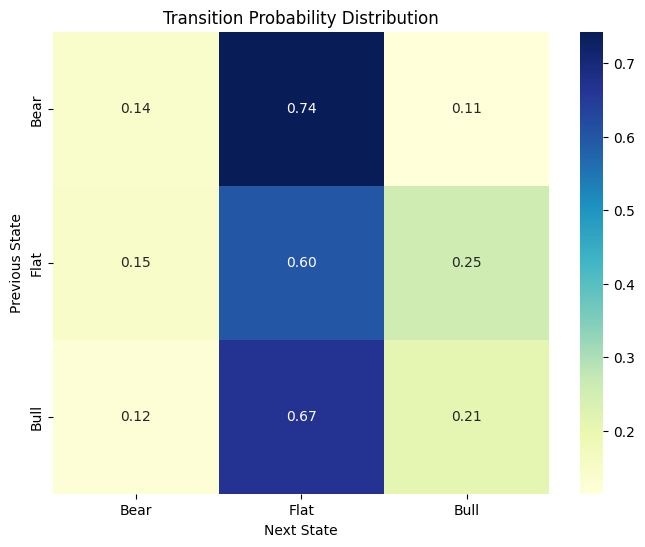

Matrix with Indices:
           Bear       Flat       Bull      
Bear       0.14       0.74       0.11      
Flat       0.15       0.60       0.25      
Bull       0.12       0.67       0.21      
Portfolio_value :  17
Optimal_Buy_Indices :  [1, 6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Buy_Dates :  ['2023-01-04', '2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07',

In [6]:
model = Modelling(price)
model.visualize_transition_probability()

## **Projecting 30-day moving average**

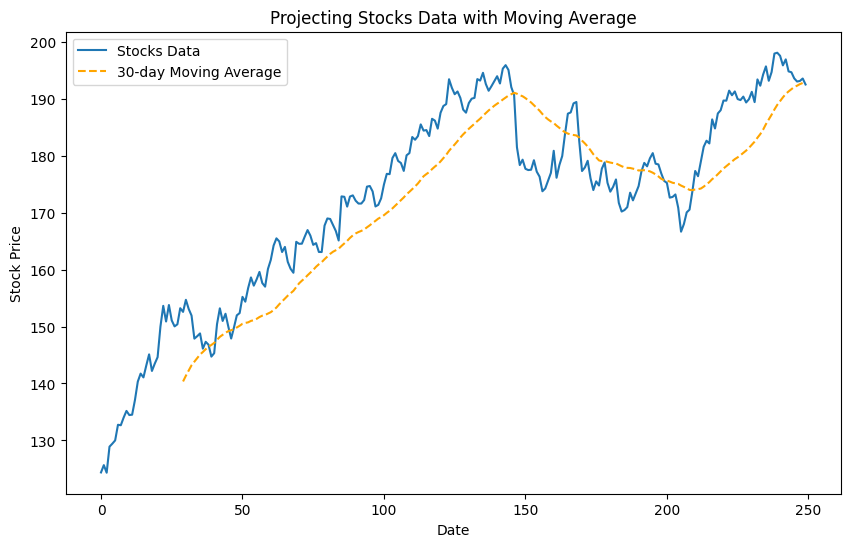

In [26]:
# Plot time series data
plt.figure(figsize=(10, 6))
plt.plot(price['Close'], label='Stocks Data')

# Calculate and plot moving average
rolling_avg = price['Close'].rolling(window=30).mean()  # Adjust window size as needed
plt.plot(rolling_avg, color='orange', linestyle='--', label='30-day Moving Average')

plt.title('Projecting Stocks Data with Moving Average')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## **Histogram of the Returns**

1      0.010316
2     -0.010608
3      0.036799
4      0.004088
5      0.004450
         ...   
245   -0.005548
246   -0.002841
247    0.000518
248    0.002226
249   -0.005424
Name: Close, Length: 249, dtype: float64


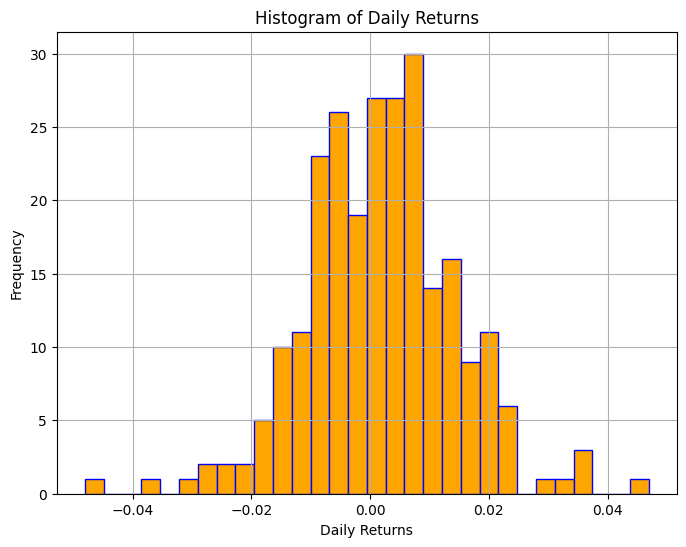

In [8]:
# Calculate daily returns
daily_returns = price['Close'].pct_change().dropna()
print(daily_returns)
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=30, color='orange', edgecolor='blue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## **Inspecting Time series components**

In [28]:
def component_analysis(df,data):
  if(df.isnull().any().any()):
    df=df.dropna()
  result = seasonal_decompose(data, model='additive', period=1)

  plt.figure(figsize=(10, 8))

  # ORIGINAL DATA
  plt.subplot(4, 1, 1)
  plt.plot(df.index, data, label='Original')
  plt.legend(loc='upper left')
  plt.title('Time Series Plot')
  plt.xticks([])

  # TREND COMPONENT
  plt.subplot(4, 1, 2)
  plt.plot(df.index, result.trend, label='Trend')
  plt.legend(loc='upper left')
  plt.title('Trend')
  plt.xticks([])

  # SEASONALITY COMPONENT
  plt.subplot(4, 1, 3)
  plt.plot(df.index, result.seasonal, label='Seasonality')
  plt.legend(loc='upper left')
  plt.title('Seasonality')
  plt.xticks([])

  # RESIDUALS
  plt.subplot(4, 1, 4)
  plt.plot(df.index, result.resid, label='Residuals')
  plt.legend(loc='upper left')
  plt.title('Residuals')
  plt.xticks([])

  plt.tight_layout()
  plt.show()


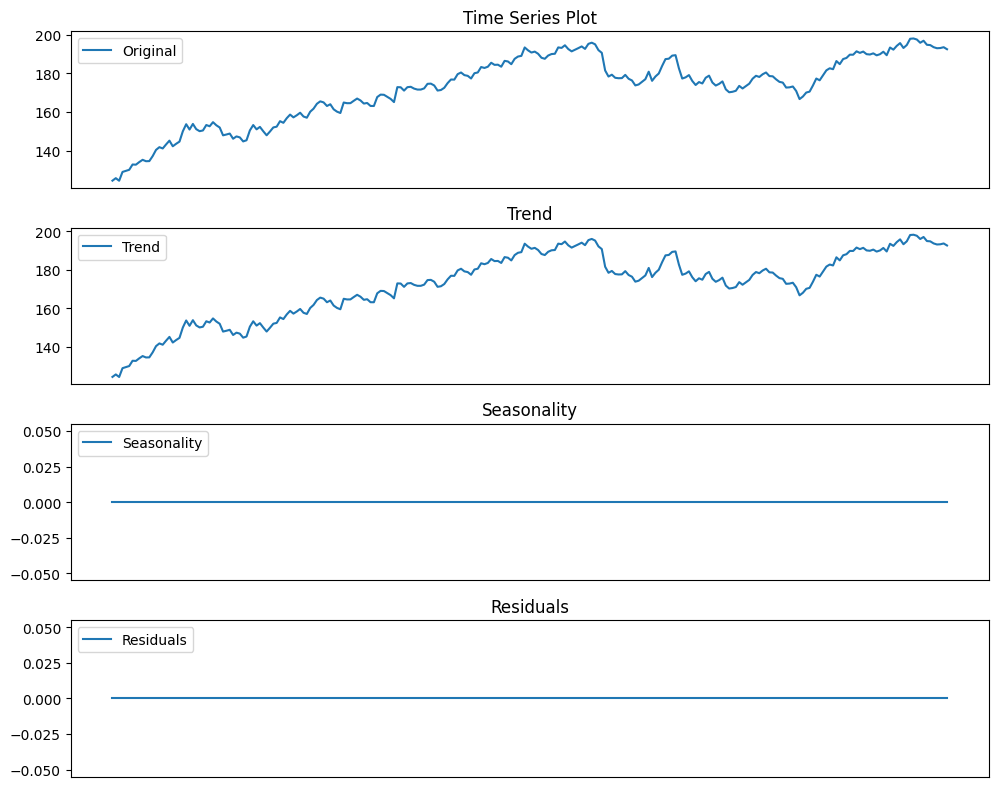

In [29]:
component_analysis(price,price['Close'])

## **Stationery Checking**

In [30]:
def kpss_test(data):
  result = kpss(data, regression='c')
  print("KPSS Statistic:", result[0])
  print("p-value:", result[1])
  print("Critical Values:", result[3])
  print('\n')
  if result[1] < 0.05:
      print("The time series is not stationary (reject the null hypothesis)")
  else:
      print("The time series is stationary (fail to reject the null hypothesis)")


In [31]:
kpss_test(price['Close'])

KPSS Statistic: 1.7159551343844486
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


The time series is not stationary (reject the null hypothesis)


In [32]:
def adfuller_test(data):
  result = adfuller(data,autolag='AIC')
  print("ADF Statistic:", result[0])
  print("p-value:", result[1])
  print("Critical Values:", result[4])
  print('\n')
  if result[1] <=0.05:
      print("The time series is stationary (reject the null hypothesis)")
  else:
      print("The time series is not stationary (fail to reject the null hypothesis)")

In [33]:
adfuller_test(price['Close'])

ADF Statistic: -2.5861110326138066
p-value: 0.09590194595133555
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}


The time series is not stationary (fail to reject the null hypothesis)


## **AUTO CORRELATION PLOT**

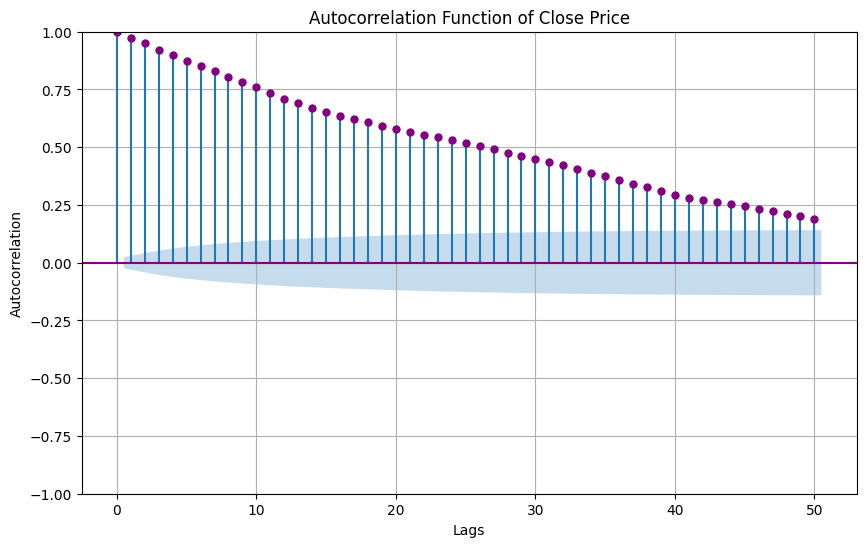

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(price['Close'], ax=ax, color='purple', alpha=0.7, lags=50)
ax.set_title('Autocorrelation Function of Close Price')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelation')
ax.grid(True)
plt.show()


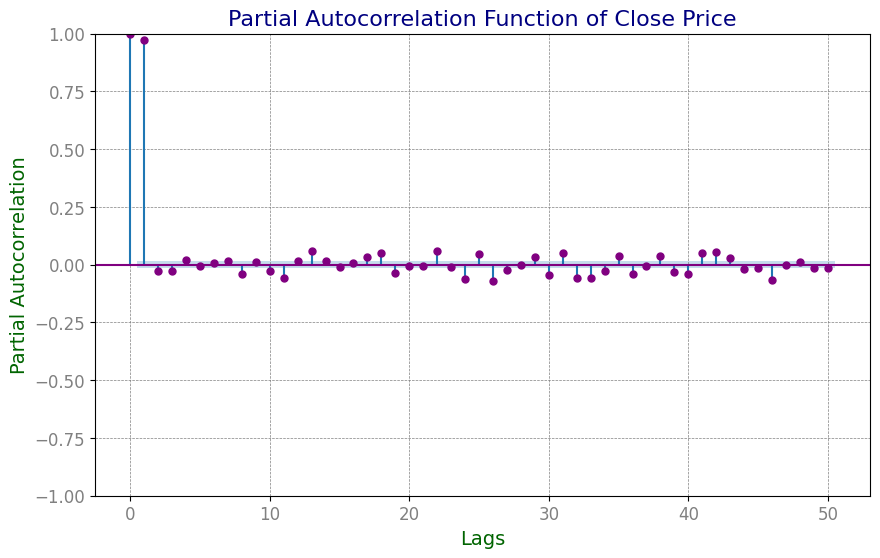

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(price['Close'], ax=ax, color='purple', alpha=0.8, lags=50)
ax.set_title('Partial Autocorrelation Function of Close Price', fontsize=16, color='navy')
ax.set_xlabel('Lags', fontsize=14, color='darkgreen')
ax.set_ylabel('Partial Autocorrelation', fontsize=14, color='darkgreen')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xticks(fontsize=12, color='gray')
plt.yticks(fontsize=12, color='gray')
plt.show()

## **Percentage change in stock prices over time**

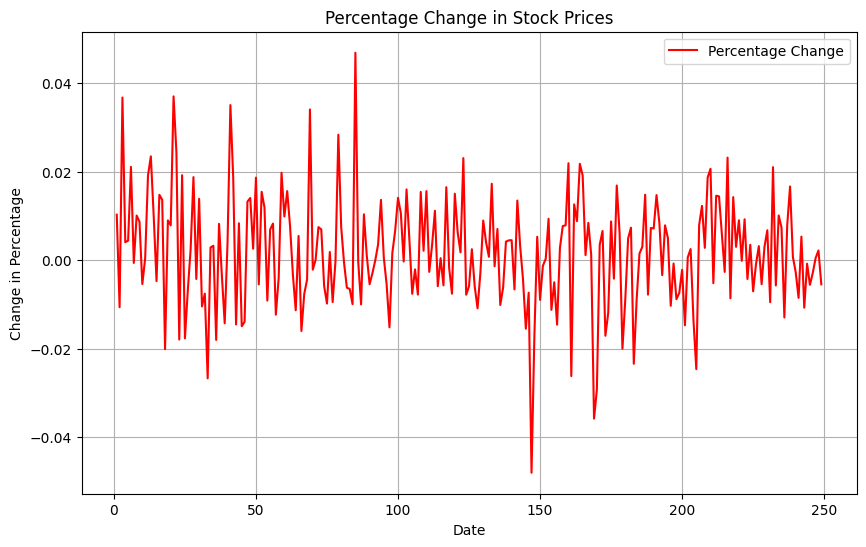

In [36]:
plt.figure(figsize=(10, 6))
plt.plot( price['Close'].pct_change(), label='Percentage Change', color='red')
plt.title('Percentage Change in Stock Prices')
plt.xlabel('Date')
plt.ylabel('Change in Percentage')
plt.legend()
plt.grid(True)
plt.show()

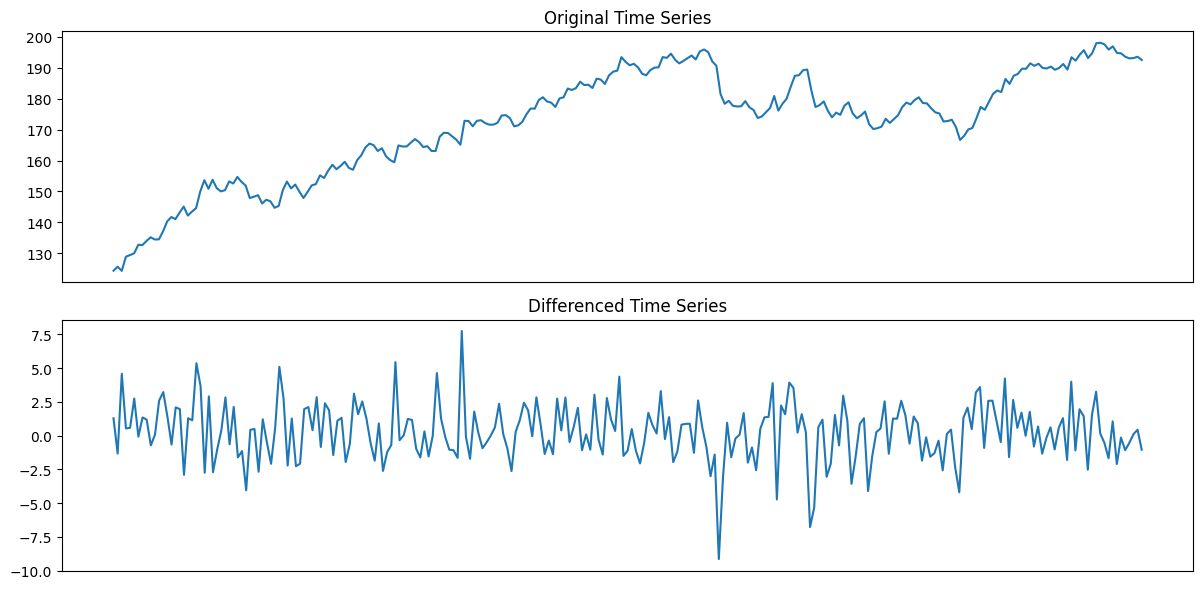

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(price['Close'])
plt.title('Original Time Series')
plt.xticks([])

differenced= price['Close'].diff().dropna()

plt.subplot(2, 1, 2)
plt.plot(differenced)
plt.title('Differenced Time Series')
plt.xticks([])

plt.tight_layout()
plt.show()

# **ARIMA MODEL**

In [38]:
X = price['Close'].values

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,18))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
print(predictions)

[182.3039976576384, 188.1086677590488, 186.53645761569612, 188.0284426859532, 189.79863062170455, 182.27005043304936, 178.1933528105623, 178.10425419369858, 182.66178256401986, 177.20526223137915, 175.15393815687602, 173.8730497894064, 171.46613297471845, 177.56603088207405, 175.91541262781516, 175.76297202615524, 173.4207077671511, 173.47651729533922, 175.83474221615683, 170.93562730369842, 172.6172325655852, 173.22359947793493, 172.0650368985156, 172.64574862337022, 169.9553868973481, 174.63228486541888, 175.50359388763667, 177.99566274837545, 177.78484036354703, 176.22794554046936, 179.48367111498584, 180.76787984235133, 180.19997993716302, 178.2895153974206, 176.6118077000608, 176.5372408670465, 174.85385470939772, 173.32064892097324, 173.82051685965732, 173.38705845772947, 170.3494262548818, 164.21475936116525, 168.44620997851894, 169.1709503678867, 171.00645009248097, 174.48911067404973, 176.47306509545425, 175.71290605225613, 179.84593232328763, 180.94703750194074, 183.047542729

## **ARIMA PLOT**

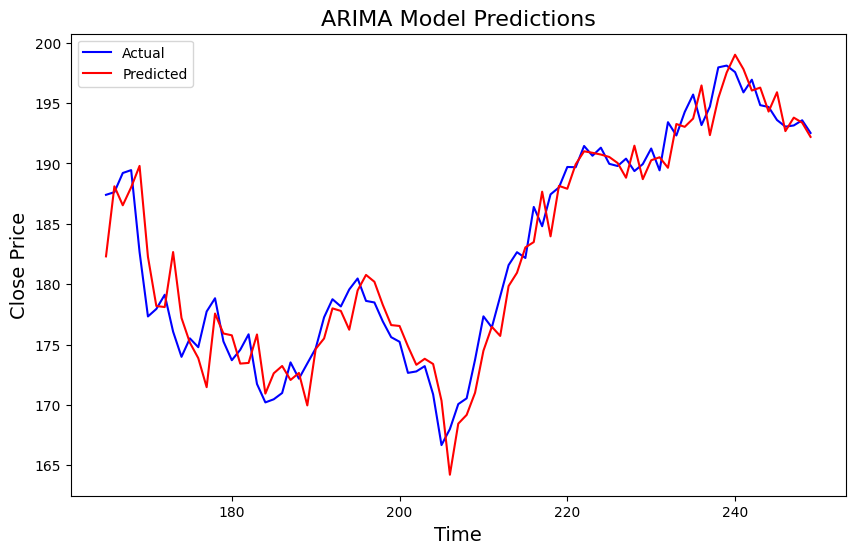

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(size, len(X)), test, color='blue', label='Actual')
plt.plot(range(size, len(X)), predictions, color='red', label='Predicted')
plt.title('ARIMA Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.show()

In [40]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.347


## **Prediction Matrix**

In [41]:
def predict_by_date(days):
  X = price['Close'].values
  train = X
  history = [x for x in train]
  predictions = list()

  # Fit the ARIMA model
  model = ARIMA(history, order=(1, 1, 18))
  model_fit = model.fit()

  # Forecast
  output = model_fit.forecast(steps=days)
  return output


In [42]:
def get_day_of_week(date_string):
    try:
        # Get the day of the week as an integer (Monday=0, Sunday=6)
        day_of_week = date_string.weekday()
        # Convert the integer day of the week to a string representation
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_name = days[day_of_week]
        return day_name
    except ValueError:
        return "Invalid date format. Please provide date in YYYY-MM-DD format."

In [43]:
def count_weekdays(start_date, end_date):
    if start_date > end_date:
        print("Error: The start date should be earlier than the end date.")
        return -1
    elif get_day_of_week(end_date) in ['Saturday', 'Sunday']:  # Check if end date is weekend
        print("It's " + get_day_of_week(end_date) + ", we can't buy Stocks")
        return -1
    else:
        current_date = start_date + timedelta(days=1)  # Start counting from the day after the start date
        weekdays_count = 0
        weekdays_dates = []
        while current_date < end_date:  # Stop before the end date
            if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
                weekdays_count += 1
                weekdays_dates.append(current_date.strftime('%Y-%m-%d'))
            current_date += timedelta(days=1)
        return weekdays_count, weekdays_dates

    Field        Date       Close
0   Close  2024-01-01  192.138310
1   Close  2024-01-02  191.461618
2   Close  2024-01-03  191.697334
3   Close  2024-01-04  192.438136
4   Close  2024-01-05  191.699032
..    ...         ...         ...
94  Close  2024-05-10  192.091498
95  Close  2024-05-13  192.091498
96  Close  2024-05-14  192.091498
97  Close  2024-05-15  192.091498
98  Close  2024-05-16  192.091498

[99 rows x 3 columns]


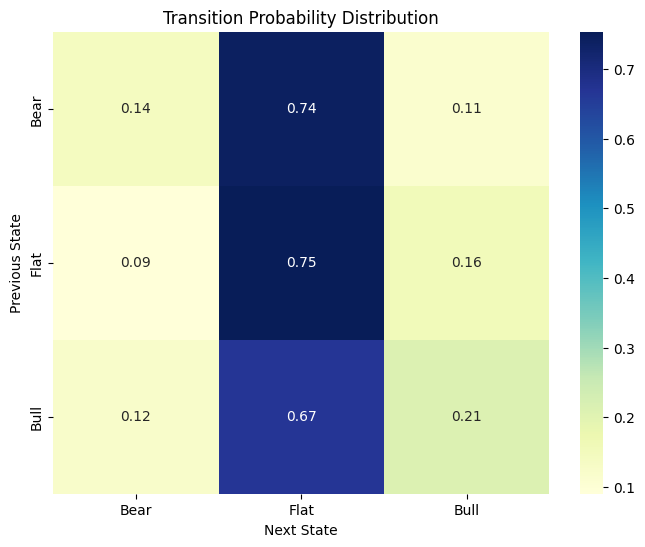

Matrix with Indices:
           Bear       Flat       Bull      
Bear       0.14       0.74       0.11      
Flat       0.09       0.75       0.16      
Bull       0.12       0.67       0.21      
Portfolio_value :  17
Optimal_Buy_Indices :  [1, 6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
Buy_Dates :  ['2023-01-04', '2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07',

In [46]:
given_date = datetime(2023, 12, 29)
last_date = datetime(2024, 5, 17)

weekdays_count, dates = count_weekdays(given_date, last_date)

if weekdays_count != 0:
    predicted_values = predict_by_date(weekdays_count)
    if predicted_values is not None:
        data_dict = {'Field':'Close','Date': dates, 'Close': predicted_values}
        new_data = pd.DataFrame(data_dict)
        print(new_data)
        new_data = price.append(new_data, ignore_index=True)
        new_model = Modelling(new_data)
        new_model.visualize_transition_probability()
        #new_model.decide_buy()
    else:
        print("Failed to make prediction")
else:
    print("No weekdays to predict")